# Training a causal language model from scratch

We’ll train a completely new model from **scratch**. This is a good approach to take if you have a **lot of data** and it is **very different from the pretraining data used for the available models**. However, it also requires considerably more compute resources to pretrain a language model than just to **fine-tune an existing one**. Examples where it can make sense to train a new model include for datasets consisting of musical notes, molecular sequences such as DNA, or programming languages. This task of text generation is best addressed with auto-regressive or causal language models such as GPT-2.

In this section we will build a scaled-down version of a code generation model: we’ll focus on one-line completions instead of full functions or classes, using a subset of Python code. When working with data in Python you are in frequent contact with the Python data science stack, consisting of the matplotlib, seaborn, pandas, and scikit-learn libraries. When using those frameworks it’s common to need to look up specific commands, so it would be nice if we could use a model to complete these calls for us.

# Gathering the data

Python code is abundantly available from code repositories such as GitHub, which we can use to create a dataset by scraping for every Python repository. This was the approach taken in the [Transformers textbook](https://learning.oreilly.com/library/view/natural-language-processing/9781098136789/) to pretrain a large GPT-2 model. Using a GitHub dump of about 180 GB containing roughly 20 million Python files called `codeparrot`, the authors built a dataset that they then shared on the [Hugging Face Hub](https://huggingface.co/datasets/transformersbook/codeparrot).

However, training on the full corpus is time- and compute-consuming, and we only need the subset of the dataset concerned with the Python data science stack. So, let’s start by **filtering the `codeparrot` dataset** for all files that include any of the libraries in this stack. Because of the dataset’s size, we want to **avoid downloading** it; instead, we’ll use the **streaming feature to filter it on the fly**. To help us filter the code samples using the libraries we mentioned earlier, we’ll use the following function:

## Filtering the data

In [1]:
def any_keyword_in_string(string: str, keywords: list[str]) -> bool:
    """
    Check if any of the keywords are in the string

    Parameters:
        string (str): The string to check
        keywords (list[str]): The keywords to check for

    Returns:
        bool: True if any of the keywords are in the string, False otherwise
    """
    for keyword in keywords:
        if keyword in string:
            return True
    return False

Let’s test it on two examples:

In [2]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters),
    any_keyword_in_string(example_2, filters)
)

False True


We can use this to create a function that will stream the dataset and **filter the elements we want**:

In [3]:
from collections import defaultdict
from tqdm.notebook import tqdm
from datasets import Dataset

In [4]:
def filter_streaming_dataset(dataset, filters, max_samples=300_000):
    """
    Filter a streaming dataset

    Parameters:
        dataset (Dataset): The streaming dataset to filter
        filters (list[str]): The keywords to filter the dataset on
        max (int): The maximum number of samples to filter

    Returns:
        Dataset: The filtered dataset

    Notes
        - Filtering the full dataset can take 2-3h depending on your
        machine and bandwidth.
    """
    filtered_dict = defaultdict(list)  # dict of lists
    total = 0  # Counting the total number of samples
    total_filtered = 0  # Counting the number of ok samples
    for sample in tqdm(iter(dataset)):  # Iterating over the dataset
        total += 1  # Incrementing the total count
        # Check if any of the filters are in the content
        if any_keyword_in_string(sample["content"], filters):
            # If so, append the sample to the filtered_dict
            for k, v in sample.items():  # Iterate over the key-value pairs
                filtered_dict[k].append(v)  # Append the data from sample
            total_filtered += 1
        # If we have filtered enough samples, break the loop
        if max_samples!=-1 and total_filtered >= max_samples:
            break

    # Print the percentage of data that is kept after filtering
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    # Return a new Dataset from the filtered_dict
    return Dataset.from_dict(filtered_dict)

Then we can simply apply this function to the streaming dataset:

In [5]:
# This cell will take a very long time to execute, so you should skip it and go to
# the next one!
from datasets import load_dataset

split = "train"  # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(
    f"transformersbook/codeparrot-{split}",
    split=split,
    streaming=True
)
filtered_data = filter_streaming_dataset(data, filters)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

0it [00:00, ?it/s]

3.26% of data after filtering.


If we set `max_samples` to "all" (-1), this leaves us with about 3% of the original dataset, which is still quite sizable — the resulting dataset is 6 GB and consists of **600,000 Python scripts**!

> Pretraining the language model will take a while. We suggest that you first run the training loop on a sample of the data by uncommenting the two partial lines above, and make sure that the training successfully completes and the models are stored. Nothing is more frustrating than a training run failing at the last step because you forgot to create a folder or because there’s a typo at the end of the training loop!

## Train and validation splits

In [6]:
raw_datasets = filtered_data.train_test_split(test_size=0.1)
# rename "test" partition to "valid"
raw_datasets['valid'] = raw_datasets.pop('test')
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 270000
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 30000
    })
})

Let’s look at an example from the dataset. We’ll just show the first 200 characters of each field:

In [7]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: ycasg/PyNLO
PATH: src/validation/Old and Partial Tests/ppln_generate_stepped_apodized_design.py
COPIES: 2
SIZE: 3351
CONTENT: # -*- coding: utf-8 -*-
"""
Created on Thu Oct 23 15:54:36 2014
This file is part of pyNLO.

    pyNLO is free software: you can redistribute it and/or modify
    it under the terms of the GNU General
LICENSE: gpl-3.0


We can see that the content field contains the code that we want our model to train on. Now that we have a dataset, we need to prepare the texts so they’re in a format suitable for pretraining.

## Tokenization

The first step will be to **tokenize the data**, so we can use it for training. Since our goal is to mainly autocomplete short function calls, we can keep the **context size relatively small**. This has the benefit that we can train the model much faster and it requires significantly less memory. If it is important for your application **to have more context** (for example, if you want the model to write unit tests based on a file with the function definition), make sure you increase that number, but also keep in mind that this comes with a greater GPU memory footprint. For now, let’s fix the context size at 128 tokens, as opposed to the 1,024 or 2,048 used in GPT-2 or GPT-3, respectively.

Most documents contain many more than 128 tokens, so simply **truncating the inputs to the maximum length** would eliminate a large fraction of our dataset. Instead, we’ll use the `return_overflowing_tokens` option to tokenize the whole input and **split it into several chunks**. We’ll also use the `return_length` option to return the length of each created chunk automatically. Often the last chunk will be smaller than the context size, and we’ll get rid of these pieces to avoid padding issues; we don’t really need them as we have plenty of data anyway.

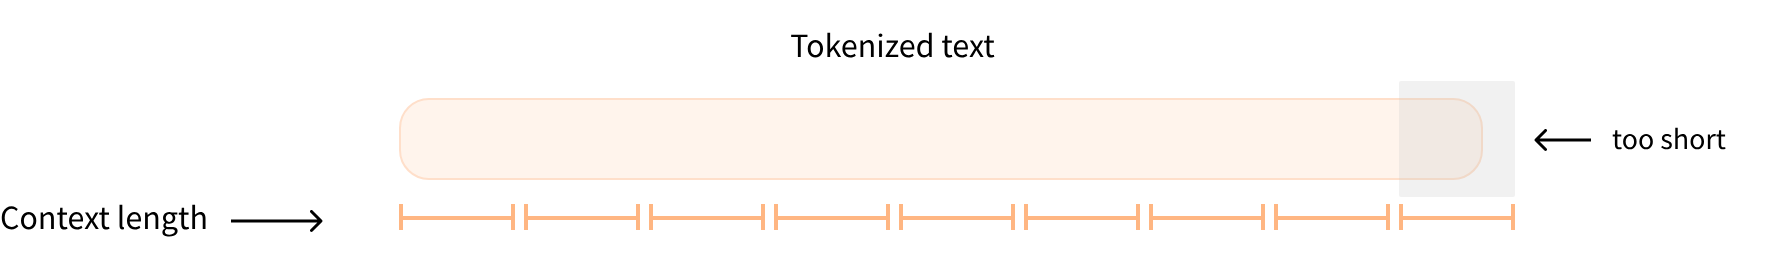

In [8]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained(
    "huggingface-course/code-search-net-tokenizer"
)

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],  # use two samples
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length (number of chunks): {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

Input IDs length (number of chunks): 17
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 111, 128, 128, 128, 128, 128, 128, 18]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


We can see that we get 31 segments in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 128 tokens (110 and 12, respectively). These represent just a small fraction of the total chunks that we have, so we can **safely throw them away**. With the `overflow_to_sample_mapping` field, we can also reconstruct which chunks belonged to which input samples.

With this operation we’re using a handy feature of the `Dataset.map()` function in Hugging Face Datasets, which is that it does not require one-to-one maps; we can create batches with more or fewer elements than the input batch. This is useful when doing operations like data augmentation or data filtering that change the number of elements. In our case, when tokenizing each element into chunks of the specified context size, we create many samples from each document. We just need to make sure to delete the existing columns, since they have a conflicting size. If we wanted to keep them, we could repeat them appropriately and return them within the `Dataset.map()` call.

> Getting rid of all the chunks that are smaller than the context size wasn’t a big issue here because we’re using small context windows. As you increase the context size (or if you have a corpus of short documents), the fraction of chunks that are thrown away will also grow. A more efficient way to prepare the data is to **join all the tokenized samples** in a batch with an `eos_token_id` token in between, and then perform the chunking on the concatenated sequences. Note that you’ll want to set **truncation=False** and remove the other arguments from the tokenizer to get the full sequence of token IDs.

In [9]:
def tokenize(elements):
    """
    Tokenize the content of the elements throwing away the overflowing tokens
    """
    outputs = tokenizer(  # Tokenize the samples to input_ids
        elements["content"],
        truncation=True,  # Truncate the content
        max_length=context_length,  # Set the maximum length per chunk
        return_overflowing_tokens=True,  # Don't discard overflowing tokens
        return_length=True,  # Return the length of each chunk
    )

    input_batch = []
    # Iterate over each chunk and its length
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        # Discard chunks that are not chunk_length
        if length == context_length:
            input_batch.append(input_ids)

    return {"input_ids": input_batch}

In [10]:
def tokenize_joining(elements):
    outputs = tokenizer(
        elements["content"],
        truncation=False
    )

    all_input_ids = []
    for iids in outputs["input_ids"]:
        all_input_ids.extend(iids + [tokenizer.eos_token_id])

    # We drop the last chunk if it's smaller than chunk_size
    total_length = len(all_input_ids)
    total_length = (total_length // context_length) * context_length

    chunks = []
    for i in range(0, total_length, context_length):
        chunks.append(all_input_ids[i:i + context_length])

    return {"input_ids": chunks}

In [11]:
tokenized_datasets = raw_datasets.map(
    tokenize_joining,
    batched=True,
    # Remove columns that are not used
    remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/270000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1263 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 7562747
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 844770
    })
})

In [12]:
# Count the number of tokens in the dataset
total_tokens = tokenized_datasets["train"].num_rows * context_length
# display the number of tokens in billions
total_tokens

968031616

We now have 7.6 million examples with 128 tokens each, which corresponds to about 968 million tokens in total. For reference, OpenAI’s GPT-3 and Codex models are trained on 300 and 100 billion tokens, respectively, where the Codex models are initialized from the GPT-3 checkpoints. Our goal in this section is not to compete with these models, which can generate long, coherent texts, but to create a scaled-down version providing a quick autocomplete function for data scientists.

# Training with Accelerate

## Custom Loss Function

Since we are mainly **interested in sensible autocompletion for the the data science libraries**, it makes sense to give more weight to training samples that make more use of these libraries. We can easily identify these examples through the use of keywords such as `plt`, `pd`, `sk`, `fit`, and `predict`, which are the most frequent import names for matplotlib.pyplot, pandas, and sklearn as well as the fit/predict pattern of the latter. If these are each represented as a single token, we can easily **check if they occur in the input sequence**. Tokens can have a whitespace prefix, so we’ll also check for those versions in the tokenizer vocabulary. To verify that it works, we’ll add one test token which should be split into multiple tokens:

In [13]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenizer([keyword]).input_ids[0]
    if len(ids) == 1:  # Check if the keyword has a single token or more
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword} -> {ids}")

Keyword has not single token: testtest -> [1824, 1824]


Great, that seems to work nicely! We can now **write a custom loss function** that takes the **input sequence, the logits, and the key tokens** we just selected as inputs.

⚠️ First we need to **align the logits and inputs: the input sequence shifted by one to the right forms the labels**, since the next token is the label for the current token. We can achieve this by starting the labels from the second token of the input sequence, since the model does not make a prediction for the first token anyway. Then we cut off the last logit, as we don’t have a label for the token that follows the full input sequence.

With that we can compute the loss per sample and count the occurrences of all keywords in each sample. Finally, we calculate the weighted average over all samples using the occurrences as weights. Since we don’t want to throw away all the samples that have no keywords, we add 1 to the weights:

Calculate the loss per sample/sequence instead of per token.

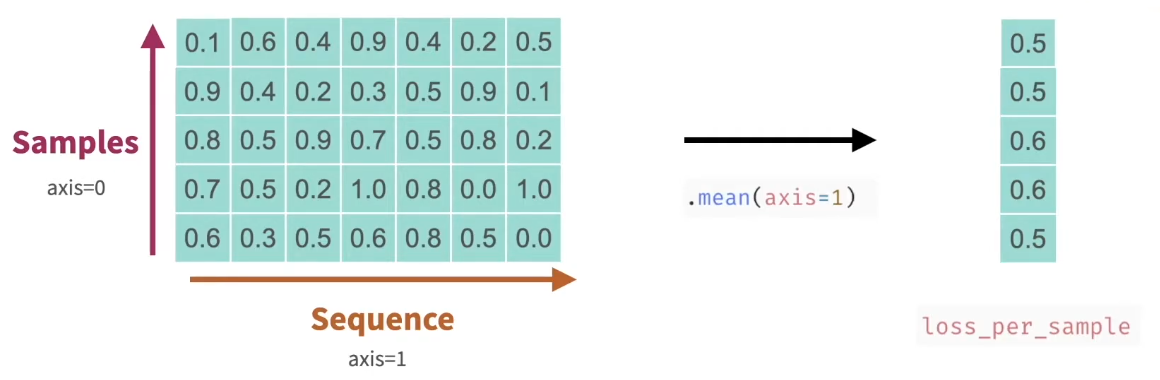

Sum the occurences across keywords and sequences.

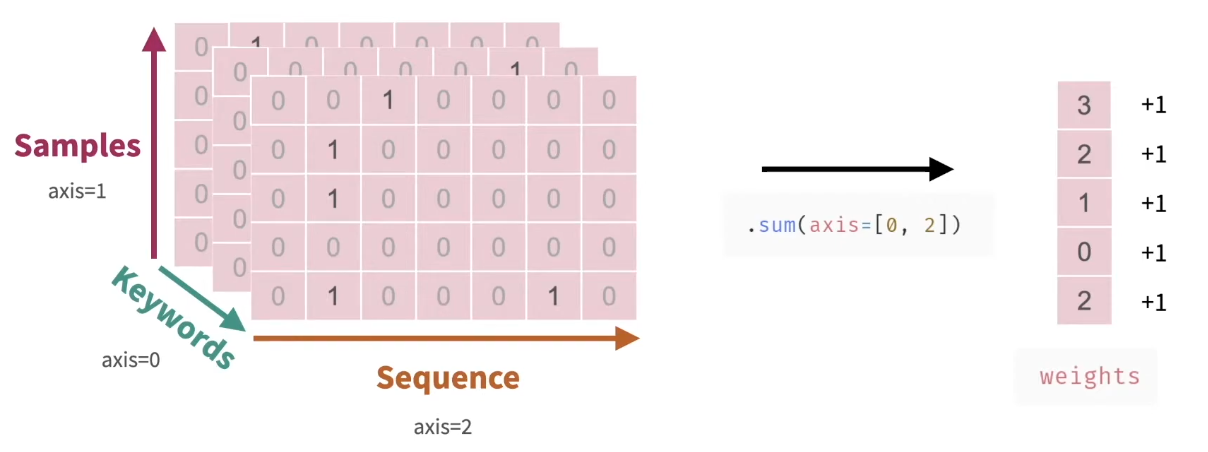

THe loss and weight are multiplied element-wise and averaged.

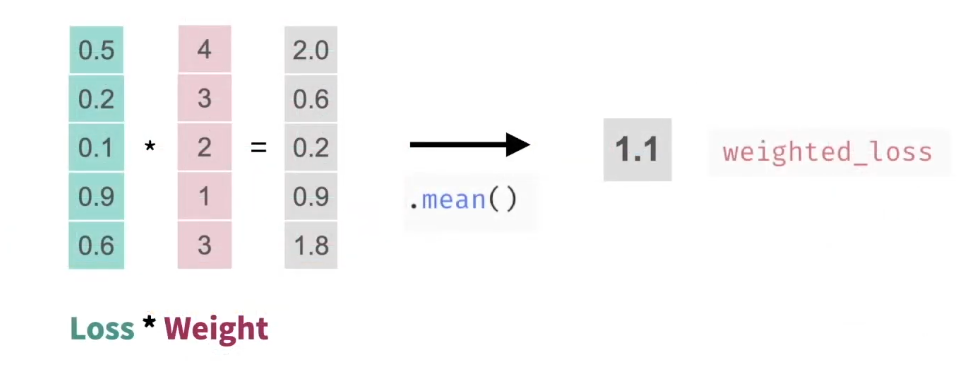

In [14]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    ####################################################################
    ######################### ALIGNMENT ################################
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()

    ####################################################################
    ############################ LOSS ##################################
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(  # Calculate the cross-entropy loss per token
        shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
    )
    # Resize and average loss per sample
    loss_per_sample = loss.view(
        shift_logits.size(0), shift_logits.size(1)
    ).mean(axis=1)  # mean accross the sequence length

    ####################################################################
    ########################## WEIGHTS #################################
    # Calculate and scale weighting
    weights = torch.stack([  # # For every keyword token generate a mask
        (inputs == kt).float() for kt in keytoken_ids  # 0s or 1s
    ]).sum(axis=[0, 2])  # Sum acrross keywords and then sequenecs
    weights = alpha * (1.0 + weights)

    ####################################################################
    ####################### LOSS * WEIGHT ##############################
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

## Data Loader

Before we can start training with this awesome new loss function, we need to prepare a few things:

- We need dataloaders to load the data in batches.
- We need to set up weight decay parameters.
- From time to time we want to evaluate, so it makes sense to wrap the evaluation code in a function.


Let’s start with the dataloaders. We only need to set the dataset’s format to "torch", and then we can pass it to a PyTorch DataLoader with the appropriate batch size:

In [15]:
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 16

tokenized_datasets.set_format("torch")
# We don't need a data collator because we have just 'input_ids'
# and we already set all of them to have the same length
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)

eval_dataloader = DataLoader(
    tokenized_datasets["valid"],
    batch_size=BATCH_SIZE
)

## Model Initialization

Freshly initialize a GPT-2 model. We’ll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and pass the `bos` and `eos` (beginning and end of sequence) token IDs:

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

With that configuration, we can load a new model. Note that this is the first time **we don’t use the `from_pretrained()`** function, since we’re actually initializing a model ourself:

In [17]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


## Weight Decay

Next, we group the parameters so that the optimizer knows which ones will get an additional weight decay. Usually, all bias and LayerNorm weights terms are exempt from this; here’s how we can do this:

In [18]:
weight_decay = 0.1


def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

We can then define our optimizer, using the function from before to split the parameters for weight decay:



In [19]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

## Accelerate

Now let’s prepare the model, optimizer, and dataloaders so we can start training:



In [20]:
from accelerate import Accelerator

accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Now that we have sent our `train_dataloader` to `accelerator.prepare()`, we can use its length to compute the number of training steps. Remember that we should always do this after preparing the dataloader, as that method will change its length. We use a classic linear schedule from the learning rate to 0:

In [21]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

## Evaluation

Since we want to evaluate the model regularly on the validation set during training, let’s write a function for that as well. It just runs through the evaluation dataloader and gathers all the losses across processes:

In [22]:
def evaluate():
    model.eval()
    losses = []
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat([loss.unsqueeze(0) for loss in losses]))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()

With the evaluate() function we can report loss and [perplexity](https://huggingface.co/course/chapter7/3) at regular intervals.

Before we train, let’s run a quick test to see if the evaluation function works properly:

In [23]:
evaluate()

  0%|          | 0/52799 [00:00<?, ?it/s]

(10.919771194458008, 55258.15234375)

Those are very high values for loss and perplexity, but that’s not surprising as we haven’t trained the model yet.

## Train

With that, we have everything prepared to write the core part of the training script: the training loop. In the training loop we iterate over the dataloader and pass the batches to the model. With the logits, we can then evaluate our custom loss function. We **scale the loss by the number of gradient accumulation** steps so as not to create larger losses when aggregating more steps. Before we optimize, we also **clip the gradients** for better convergence. Finally, every few steps we evaluate the model on the evaluation set with our new evaluate() function:

In [24]:
output_dir = f"tmp/clm-pt_codeparrot_ds-{context_length}"

In [ ]:
gradient_accumulation_steps = 16
samples_per_step = BATCH_SIZE
eval_steps = 5_000

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=num_training_steps
    ):
        logits = model(batch["input_ids"]).logits
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)

        if step % 100 == 0:
            accelerator.print(
                {
                    "samples": step * samples_per_step,
                    "steps": completed_steps,
                    "loss/train": loss.item() * gradient_accumulation_steps,
                }
            )
        loss = loss / gradient_accumulation_steps
        accelerator.backward(loss)

        # After gradient_accumulation_steps steps, update the model
        if step % gradient_accumulation_steps == 0:
            # Gradient clipping
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            # Update the model
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1


        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()
            accelerator.print({"loss/eval": eval_loss, "perplexity": perplexity})

            model.train()
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)

In [ ]:
evaluate()

# Code generation with a pipeline

Now is the moment of truth: let’s see how well the trained model actually works! We can see in the logs that the loss went down steadily, but to put the model to the test let’s take a look at how well it works on some prompts. To do that we’ll wrap the model in a text generation pipeline, and we’ll put it on the GPU for fast generations if there is one available:

In [26]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation",
    model=output_dir,
    device=device
)

In [74]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
sc = ax.scatter(x, y)
# set


In [92]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
from pandas import Series, DataFrame
df = DataFrame({'x': x


Looking at these few examples, it seems that the model has learned some of the syntax of the Python data science stack (of course, we would need to evaluate it more thoroughly before deploying the model in the real world). Sometimes it requires more customization of the model training to achieve the necessary performance for a given use case, however. For example, what if we would like to dynamically update the batch size or have a conditional training loop that skips bad examples on the fly? One option would be to subclass the Trainer and add the necessary changes, but sometimes it’s simpler to write the training loop from scratch. Check the [Accelerate Notebook](pt_causal_scratch.ipynb).